In [1]:
from Functions import *
import scipy.interpolate as interpolate
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + '2DCM_111_440/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/2DCM_111_440/


In [4]:
def define_beamline(
    E0, alphaAsym1 = 9.0, alphaAsym2 = 5.5, shapeErrors=[None for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    ## HHLM
    asym1 = np.deg2rad(alphaAsym1)
    asym2 = np.deg2rad(alphaAsym2)
    hhlm1 = optics.Crystal('HHLM1', hkl=[1,1,1], length=5e-2, width=1e-1, z=305+z_s, alphaAsym=-asym1, E0=E0, 
                           orientation=0, pol='s', shapeError=shapeErrors[0])
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=30e-3,N=256,z=hhlm1.z+.01)
    
    hhlm2 = optics.Crystal('HHLM2', hkl=[1,1,1], length=5e-2, width=1e-1, z=hhlm1.z+139e-3, alphaAsym=asym1, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[3])
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=30e-3,N=256,z=hhlm2.z+.01)
    
    hhlm3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=5e-2, width=1e-1, z=hhlm1.z+361e-3, alphaAsym = -asym2, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[1])
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=30e-3,N=256,z=hhlm3.z+.01)
    
    hhlm4 = optics.Crystal('HHLM4', hkl=[4,4,0], length=5e-2, width=1e-1, z=hhlm1.z+.5, alphaAsym = asym2, E0=E0,
                           orientation=0, pol='s', shapeError=shapeErrors[2])
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=5e-3,N=256,z=hhlm4.z+.01)

    HHLM_devices = [im_input, hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]
    
    all_devices = HHLM_devices
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline

### Beam profiles along the beamline

In [5]:
%%capture capt
#### Time domain propagation
alphaAsym1 = 9.0   # asymmetry angle [degree]
alphaAsym2 = 15.0

beam_params['photonEnergy'] = E0

mono_beamline = define_beamline(E0, alphaAsym1=alphaAsym1, alphaAsym2 = alphaAsym2)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=200e-3, N=100)

screen_names = ['im_input', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4']

pulse.propagate(beamline=mono_beamline, screen_names=screen_names)


path exists


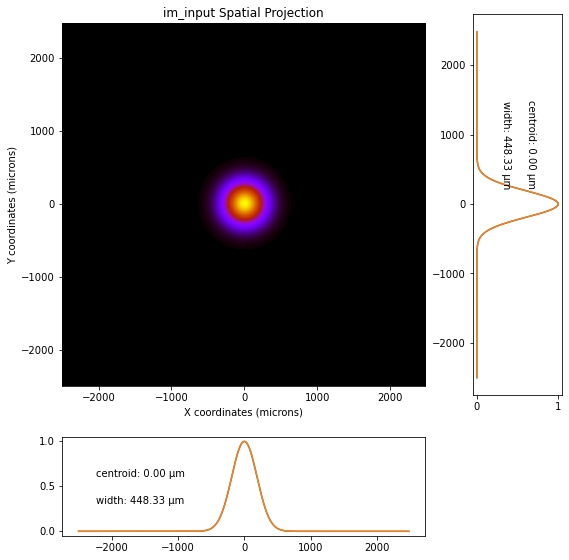

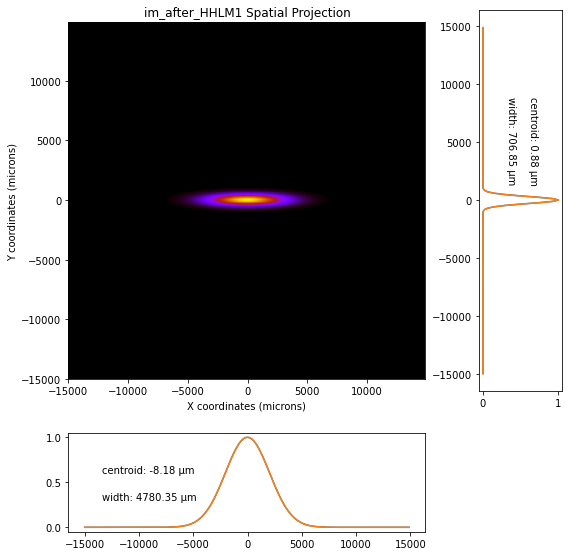

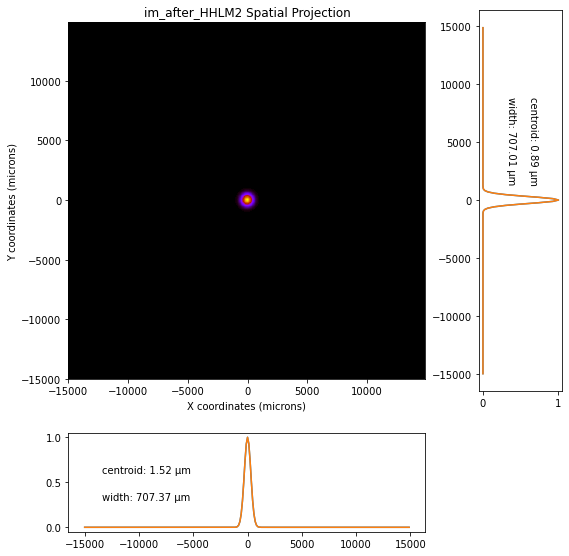

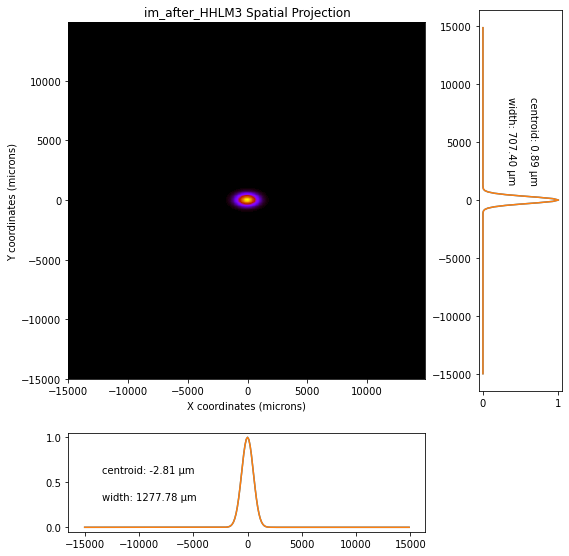

In [ ]:
''' projection '''
dir_perfect = dir_case + '{}_{}_deg/'.format(alphaAsym1, alphaAsym2); make_dir(dir_perfect)
for screen_name in pulse.screens:
    try:
        pulse.imshow_projection(screen_name)
        plt.savefig(dir_perfect+'projection_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')

In [ ]:
''' energy slices '''
for screen_name in pulse.screens:
    try:
        pulse.imshow_energy_slice(screen_name)
        plt.savefig(dir_perfect+'spectrum_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')


In [ ]:
''' plot time slices '''
shift = 0
for screen_name in pulse.screens:
    try:
        pulse.imshow_time_slice(screen_name, shift=shift)
        plt.savefig(dir_perfect+'tilt_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')

In [ ]:
''' diagnostics '''
c, pulse_duration0 = pulse.pulse_duration('im_after_HHLM4')
pulse_tilt0 = pulse.pulsefront_tilt('im_after_HHLM4')
spatial_chirp0 = pulse.spatial_chirp('im_after_HHLM4')
energy_bandwidth0 = pulse.pulse_bandwidth('im_after_HHLM4')

print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))

# np.savetxt(dir_perfect+'diagnostics_type.txt',np.array(['duration [fs]', 'tilt [fs/um]', 'chirp [meV/um]', 'bandwidth [meV]']), delimiter=',')
np.savetxt(dir_perfect+'diagnostics_value.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')


In [ ]:
import winsound
winsound.Beep(1500, 3000)